In [1]:
import cobra
import thermo_flux
import thermo_flux.tools
import pandas as pd
import numpy as np

import os.path as path

from thermo_flux.io import load_excel as ex
from thermo_flux.io import helper_load as hl

from equilibrator_api import  Q_

from thermo_flux.solver.gurobi import variability_analysis

from cobra.flux_analysis import flux_variability_analysis

In [2]:
INPUT_MODEL = "datafiles/model.xlsx"
INPUT_KEGGS = "datafiles/ecoli_kegg_id.csv"
INPUT_REED = "datafiles/reed.csv"
INPUT_INCHI = "datafiles/InChIs.csv"
INPUT_GAMS = "datafiles/model_Ecoli_from-gams.xlsx"
INPUT_EXP_DATA = "datafiles/allPhysioData_formatted_forGSM_20230831.csv"
INPUT_EXP_CONC = "datafiles/allConcRange_20230912.csv"
INPUT_METABOLOMICS = "datafiles/metabolomics-Kochanowski_20230925.csv"

MODEL_NAME = "ecoli"
CONDITIONS = ["WT-Glc_I", "WT-Ace_I"]

INCLUDE_CO2 = True
INCLUDE_O2 = True
ALLOW_OTHER_EXCRETION = False
RELAX_EXP_FLUX_BOUNDS = 2.0

In [3]:
def gen_model(name: str, model_xlsx: str, kegg: str, reed: str, inchi:str, gams: str, output_log: str, add_o2: bool, add_co2: bool, update_thermodynamics=True):
    tmodel = ex.create_thermo_model(name, model_excel=model_xlsx, keggids_csv=kegg, edit_mets={})

    # ADD HYDROXYBENZOATE TRANSPORT & EXCHANGE:
    # Define extracellular orotate:
    hbz_e = cobra.Metabolite(id="4hbz_e", compartment="e")
    hbz_e = thermo_flux.core.metabolite.ThermoMetabolite(hbz_e, model=tmodel)
    hbz_e.annotation = tmodel.metabolites.get_by_id("4hbz_c").annotation  
    tmodel.metabolites.append(hbz_e)

    # Hydroxybenzoate H+ antiporter (aaeB):
    HBZt3 = cobra.Reaction("HBZt3")
    HBZt3.lower_bound = -1000
    HBZt3.upper_bound = 1000
    HBZt3.add_metabolites({tmodel.metabolites.get_by_id("4hbz_e"): +1,
                      tmodel.metabolites.h_e: -1,
                      tmodel.metabolites.get_by_id("4hbz_c"): -1,
                      tmodel.metabolites.h_c: +1})
    HBZt3 = thermo_flux.core.reaction.ThermoReaction(HBZt3, model=tmodel)

    # Exchange:
    EX_4hbz = cobra.Reaction("EX_4hbz")
    EX_4hbz.add_metabolites({tmodel.metabolites.get_by_id("4hbz_e"): -1})
    EX_4hbz = thermo_flux.core.reaction.ThermoReaction(EX_4hbz, model=tmodel)

    tmodel.add_reactions([HBZt3, EX_4hbz])

    # ADD ISOPROPYLMALATE TRANSPORT & EXCHANGE:
    # Define extracellular orotate:
    ipm_e = cobra.Metabolite(id="3c3hmp_e", compartment="e")
    ipm_e = thermo_flux.core.metabolite.ThermoMetabolite(ipm_e, model=tmodel)
    ipm_e.annotation = tmodel.metabolites.get_by_id("3c3hmp_c").annotation  
    tmodel.metabolites.append(ipm_e)

    # Diffusion across the membrane:
    ipm_diff = cobra.Reaction("IPMex")
    ipm_diff.lower_bound = -1000
    ipm_diff.upper_bound = 1000
    ipm_diff.add_metabolites({tmodel.metabolites.get_by_id("3c3hmp_c"): -1,
                            tmodel.metabolites.get_by_id("3c3hmp_e"): +1})
    ipm_diff = thermo_flux.core.reaction.ThermoReaction(ipm_diff, model=tmodel)

    # Exchange:
    EX_3c3hmp = cobra.Reaction("EX_3c3hmp")
    EX_3c3hmp.add_metabolites({tmodel.metabolites.get_by_id("3c3hmp_e"): -1})
    EX_3c3hmp = thermo_flux.core.reaction.ThermoReaction(EX_3c3hmp, model=tmodel)

    tmodel.add_reactions([ipm_diff, EX_3c3hmp])

    # ADD OROTATE TRANSPORT AND EXCHANGE
    # Define extracellular orotate:
    oro_e = cobra.Metabolite(id="orot_e", compartment="e")
    oro_e = thermo_flux.core.metabolite.ThermoMetabolite(oro_e, model=tmodel)
    oro_e.annotation = tmodel.metabolites.orot_c.annotation  
    tmodel.metabolites.append(oro_e)

    # Diffusion across the membrane:
    oro_diff = cobra.Reaction("OROTex")
    oro_diff.lower_bound = -1000
    oro_diff.upper_bound = 1000
    oro_diff.add_metabolites({tmodel.metabolites.orot_c: -1,
                            tmodel.metabolites.orot_e: +1})
    oro_diff = thermo_flux.core.reaction.ThermoReaction(oro_diff, model=tmodel)

    # Dicarboxylate/H+ symporter (dctA):
    dcta = cobra.Reaction("DCTA")
    dcta.lower_bound = -1000
    dcta.upper_bound = 0
    dcta.add_metabolites({tmodel.metabolites.orot_e: +1,
                        tmodel.metabolites.h_e: +1,
                        tmodel.metabolites.orot_c: -1,
                        tmodel.metabolites.h_c: -1})
    dcta = thermo_flux.core.reaction.ThermoReaction(dcta, model=tmodel)

    # Exchange:
    EX_oro = cobra.Reaction("EX_oro")
    EX_oro.add_metabolites({tmodel.metabolites.orot_e: -1})
    EX_oro = thermo_flux.core.reaction.ThermoReaction(EX_oro, model=tmodel)

    tmodel.add_reactions([oro_diff, dcta, EX_oro])

    # Define thermodynamic parameters
    tmodel.pH = {"c": Q_(7.6), "e": Q_(7)} #pH
    tmodel.I = {"c": Q_(0.25,'M'), "e": Q_(0.25,'M')} #ionic stength
    tmodel.phi = {'ce':Q_(0.15,'V')} #membrane potential ‘ce’ represents the voltage between compartment ‘c’ and compartment 'e’ defined as Phic - Phie
    tmodel.pMg = {'e': Q_(3), 'c': Q_(3)}

    # Update metabolite annotations with the IDs from KEGG
    for met in tmodel.metabolites:
        met.annotation["bigg.metabolite"] = met.id[:-2]

    # Update the inchi strings of some unknown metabolites
    df = pd.read_csv(reed, header=None).set_index(0)

    unknown_mets = []
    for met in tmodel.metabolites:
        if met.id[:-2] in df.index:
            met.annotation['InChI'] = df.loc[met.id[:-2]].iloc[1]
            unknown_mets.append(met)

    for met in tmodel.metabolites:
        if ('kegg' in met.annotation):
            if (met.annotation['kegg'] in df.index):
            
                inchi = df.loc[met.annotation['kegg']].iloc[0]

                if type(inchi) is str:
                    met.annotation['InChI'] = df.loc[met.annotation['kegg']].iloc[0]
                    unknown_mets.append(met)

    # Additional data from excel spredsheet needs to be imported for some compounds with unknown structure
    sheets = ex.read_excelfile(model_xlsx)

    for met in tmodel.metabolites:
        if met.id[:-2] in sheets['Metabolites']['Unnamed: 0'].values:

            common_name = sheets['Metabolites'].loc[sheets['Metabolites']['Unnamed: 0'] == met.id[:-2]]['Unnamed: 11'].values
            protons = sheets['Metabolites'].loc[sheets['Metabolites']['Unnamed: 0'] == met.id[:-2]]['Unnamed: 9'].values
            charge =  sheets['Metabolites'].loc[sheets['Metabolites']['Unnamed: 0'] == met.id[:-2]]['Unnamed: 8'].values
            formula =  sheets['Metabolites'].loc[sheets['Metabolites']['Unnamed: 0'] == met.id[:-2]]['Unnamed: 12'].values

            met.formula = 'H'+str(protons[0])

            if len(common_name) > 0:
                met.notes['common name'] = common_name[0]
                met.charge = charge[0]
            else:
                met.notes['common name'] = ''

    # Hydrogenase reactions are missing protons
    for rxn in tmodel.reactions:
        if 'HYD' in rxn.id:
            if 'ATP' not in rxn.id:
                rxn.add_metabolites({tmodel.metabolites.h_e:2,
                                    tmodel.metabolites.h_c:-2})

    # Remove duplicate/additional reactions
    RXNS_TO_REMOVE = []
    for rxn in tmodel.reactions:
        if rxn.id.endswith("_add"):
            RXNS_TO_REMOVE.append(rxn)   
    tmodel.remove_reactions(RXNS_TO_REMOVE)

    # FDH reactions are missing protons and water is on wrong side of membrane 
    tmodel.reactions.FDH2.add_metabolites({tmodel.metabolites.h_e:2,
                                        tmodel.metabolites.h_c:-2,
                                        tmodel.metabolites.h2o_c:1,
                                        tmodel.metabolites.h2o_e:-1})
    tmodel.reactions.FDH3.add_metabolites({tmodel.metabolites.h_e:2,
                                        tmodel.metabolites.h_c:-2,
                                        tmodel.metabolites.h2o_c:1,
                                        tmodel.metabolites.h2o_e:-1})

    # Missing transporterd metabolites
    tmodel.reactions.TMAOR1e.transported_mets = {tmodel.metabolites.tmao_e: -1}
    tmodel.reactions.TMAOR2e.transported_mets = {tmodel.metabolites.tmao_e: -1}
    tmodel.reactions.GLCDe.transported_mets = {tmodel.metabolites.get_by_id('glc-D_e'): -1}

    #D MSOR1e protons are incorrect - this resets the reaction to the bigg version 
    tmodel.reactions.DMSOR1e.add_metabolites({tmodel.metabolites.h_e:-2,
                                            tmodel.metabolites.h_c:2 })
    tmodel.reactions.DMSOR2e.add_metabolites({tmodel.metabolites.h_e:-2,
                                            tmodel.metabolites.h_c:2 })

    tmodel.reactions.DMSOR1e.transported_mets = {tmodel.metabolites.dmso_e: -1}
    tmodel.reactions.DMSOR2e.transported_mets = {tmodel.metabolites.dmso_e: -1}

    tmodel.reactions.SHCHF.add_metabolites({tmodel.metabolites.scl_c:-1,
                                            tmodel.metabolites.srch_c:1})

    # Sirohydrochlorin dehydrogenase is incorrectly defined in model 
    tmodel.reactions.SHCHD2.add_metabolites({tmodel.metabolites.scl_c:2,
                                            tmodel.metabolites.srch_c:-2})

    #Update srch metabolite name
    tmodel.metabolites.srch_c.annotation = {'bigg.metabolite': 'dscl'}

    # Specific reaction that invovled chemcial transformation as part of transport
    tmodel.reactions.NMNt7.transported_mets = {tmodel.metabolites.nmn_e:-1}

    # PTS mechanism 
    for rxn in tmodel.reactions:
        if 'pts' in rxn.id:
            rxn.transported_mets = {met:stoich for met, stoich in rxn.metabolites.items() if met.compartment == 'e'}

    #in imported model any charge metabolite represents a free cation that is transported 
    for rxn in tmodel.reactions:
        if 'biomass' not in rxn.id:   # ignore biomass reaction 
            
            transported_charge = {}
            for met, stoich in rxn.metabolites.items():
                if (met in tmodel.charge_dict.values()):
                    transported_charge[met.compartment] = stoich
            
            if len(transported_charge) != 0:
                rxn.transported_charge = transported_charge

    # Load default concentration bounds from the GAMS model:
    df_conc = hl.excel_to_df(gams)["ConcLimits"]

    # Rearrange data for easier use:
    df_conc = df_conc.reset_index()
    df_conc["met"] = df_conc["dim1"] + "_"+ df_conc["dim2"]
    df_conc = df_conc.pivot_table(columns="dim3", values="Value", index="met")

    # Change upper and lower concentration bounds the values in the dataframe df_conc (taken from GAMS)
    # (values are in mM)
    for met, row in df_conc.iterrows():
        tmodel.metabolites.get_by_id(met).upper_bound = Q_(row["up"], "mM")
        tmodel.metabolites.get_by_id(met).lower_bound = Q_(row["lo"], "mM")

    # Find correct biomass reaction
    biomass_rxns = [r for r in tmodel.reactions if 'biomass' in r.id.lower()]
    for r in biomass_rxns:
        print(r.id, ":", r.reaction[:80])

    # Correct reaction is 'biomass'
    # Define the protons in biomass 
    tmodel.metabolites.biomass_c.formula = 'H74'  # estimated http://www.ncbi.nlm.nih.gov/pubmed/20506321
    tmodel.metabolites.biomass_e.formula = 'H74'

    # Assign biomass
    tmodel.metabolites.biomass_c.biomass = True
    tmodel.metabolites.biomass_e.biomass = True

    tmodel.reactions.biomass.add_metabolites({tmodel.metabolites.atp_c: -31.2622,
                                                tmodel.metabolites.h2o_c: -31.2622,
                                                tmodel.metabolites.adp_c: +31.2622,
                                                tmodel.metabolites.pi_c:  +31.2622})


    # Define biomass formation energy: dfG0(biomass) [kJ gCDW-1] = -2.692234848 fom Battley 1991
    base_dfg = (Q_(-2.692234848, "kJ/mol") * 1000) # values in J/gDW 

    tmodel.metabolites.biomass_c.dfG0 = base_dfg
    tmodel.metabolites.biomass_e.dfG0 = base_dfg

    tmodel.reactions.biomass_ce.ignore_snd = True

    if update_thermodynamics:
        for rxn in tmodel.reactions:
            thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False)

        for met in tmodel.metabolites:
            if met.id in ['charge_c', 'charge_m', 'charge_e']:
                met.ignore_conc = True
        tmodel.update_thermo_info(fit_unknown_dfG0=True)

    return tmodel

In [4]:
def apply_metabolome_physio_data(tmodel, condition :str, input_exp: str, input_conc: str, input_metabolomics: str, input_gams: str, relax_flux_bounds, include_CO2: bool, include_O2: bool, allow_other_excr: bool, output_log: str, open_exchanges=False, flux_limit = 100):
    "Apply metabolome and physiological data to base stoichiometric-thermodynamic ecoli model"
    df_conc = hl.excel_to_df(input_gams)["ConcLimits"]

    # Rearrange data for easier use:
    df_conc = df_conc.reset_index()
    df_conc["met"] = df_conc["dim1"] + "_"+ df_conc["dim2"]
    df_conc = df_conc.pivot_table(columns="dim3", values="Value", index="met")

    # Import experimental data:
    reg_data = pd.read_csv(input_exp)

    reg_data.set_index(["cond", "rxn"], inplace=True) 
    reg_data.head()

    # Store gas fluxes:
    reg_data_gas = reg_data.swaplevel().copy()
    reg_data_gas = reg_data_gas.loc[["EX_co2", "EX_o2"]]
    reg_data_gas = reg_data_gas.swaplevel()
    reg_data_gas

    if include_CO2 is False:
        reg_data_no_gas = reg_data.swaplevel().copy()
        reg_data_no_gas = reg_data_no_gas.drop(["EX_co2"])
        reg_data_no_gas = reg_data_no_gas.swaplevel()
        reg_data = reg_data_no_gas
        
        
    if include_O2 is False:
        reg_data_no_gas = reg_data.swaplevel().copy()
        reg_data_no_gas = reg_data_no_gas.drop(["EX_o2"]) 
        reg_data_no_gas = reg_data_no_gas.swaplevel()
        reg_data = reg_data_no_gas

    # Set metabolite concentrations to the values in the GAMS model:   
    for met, row in df_conc.iterrows():
        tmodel.metabolites.get_by_id(met).upper_bound = Q_(row["up"], "mM")
        tmodel.metabolites.get_by_id(met).lower_bound = Q_(row["lo"], "mM")

    # Import experimental data:
    conc_data = pd.read_csv(input_conc)

    conc_data.set_index(["cond", "met"], inplace=True) 
    conc_data.head()

    available_conditions = ["WT-Glc_I", "WT-Gal_I", "WT-Fruc_I", "WT-Mann_I", "dptsG-Glc_I", "WT-Ace_I", "WT-Succ_I", "WT-Fum_I", "WT-Glyc_I", "WT-Pyr_I", "WT-GlyCAA_II"]
    volume_data = pd.DataFrame({cond: {"c": 1.0} for cond in available_conditions} ).T #specify the volume fractions for each condition
    volume_data.head()

    # Import experimental data:
    met_data = pd.read_csv(input_metabolomics)
    met_data.set_index(["cond", "met"], inplace=True) 
    met_data.head()

    conds_with_data = list(met_data.reset_index().cond.unique())
    missing_conds = [cond for cond in available_conditions if cond not in conds_with_data]

    df_missing = pd.DataFrame({"cond": missing_conds, 
                            "met": "g6p",
                            "mean": np.nan, 
                            "sd": np.nan, }).set_index(["cond", "met"])

    # Apply metabolome data
    met_data = pd.concat([met_data, df_missing])
    met_data_all=pd.read_csv(input_metabolomics, index_col=(0,1))

    df_bounds=thermo_flux.solver.gurobi.calc_conc_bounds(tmodel,[condition],met_data_all,conc_units='mM')
    df_bounds_cond=df_bounds.loc[condition]
    for met_id,row in df_bounds_cond.iterrows():
        tmodel.metabolites.get_by_id(met_id).upper_bound=Q_(row['ub'],'M')
        tmodel.metabolites.get_by_id(met_id).lower_bound=Q_(row['lb'],'M')
    
    exchanges = [rxn.id for rxn in tmodel.exchanges]

    exchanges_to_relax = ["EX_C", "EX_h", "EX_h2o", "EX_k", "EX_nh3", "EX_pi", "EX_so4"]

    if include_CO2 is False:
        exchanges_to_relax += ["EX_co2"]
        
    if include_O2 is False:
        exchanges_to_relax += ["EX_o2"]

    if allow_other_excr is True:
        upper_bound_exchanges = 100
    else:
        upper_bound_exchanges = 0

    # Reset all flux bounds to +- flux limit (default -100 / 100):
    for rxn in tmodel.reactions:
        tmodel.reactions.get_by_id(rxn.id).lower_bound = -flux_limit
        tmodel.reactions.get_by_id(rxn.id).upper_bound = flux_limit
    
    # Add non-growth associate ATP maintenance cost:
    tmodel.reactions.ATPHYD.lower_bound = 3.15

    # Fix exchange reaction directions:
    for rxn in exchanges:
        tmodel.reactions.get_by_id(rxn).lower_bound = 0
        tmodel.reactions.get_by_id(rxn).upper_bound = upper_bound_exchanges
  
    # Relax essential exchanges:
    for rxn_rel in exchanges_to_relax:
        tmodel.reactions.get_by_id(rxn_rel).lower_bound = -flux_limit
        tmodel.reactions.get_by_id(rxn_rel).upper_bound = +flux_limit

    # Fix flux for the measured exchange reactions:
    for rxn, row in reg_data.loc[condition].iterrows():
        tmodel.reactions.get_by_id(rxn).lower_bound = -flux_limit
        tmodel.reactions.get_by_id(rxn).upper_bound = flux_limit

        if not open_exchanges:
            tmodel.reactions.get_by_id(rxn).lower_bound = row["mean"] - relax_flux_bounds * row["sd"]
            tmodel.reactions.get_by_id(rxn).upper_bound = row["mean"] + relax_flux_bounds * row["sd"]

    if condition.startswith("dptsG-Glc"):
        tmodel.reactions.GLCpts.lower_bound = 0
        tmodel.reactions.GLCpts.upper_bound = 0
        
    # Fix concentration for the measured extracellular metabolites:
    for met, row in conc_data.loc[condition].iterrows():
        tmodel.metabolites.get_by_id(met).lower_bound = Q_(1e-9, "M")
        tmodel.metabolites.get_by_id(met).upper_bound = Q_(100, "M")
        tmodel.metabolites.get_by_id(met).lower_bound = Q_(row["conc_M_min"], "M")
        tmodel.metabolites.get_by_id(met).upper_bound = Q_(row["conc_M_max"], "M")

    #Normalize reaction fluxes to native floats otherwise SBML will error out when exporting

    for met_id, row in df_bounds_cond.iterrows():
        print(f"model: {tmodel.metabolites.get_by_id(met_id).lower_bound}, {tmodel.metabolites.get_by_id(met_id).upper_bound}, metabolome: {row['lb']}, {row['ub']}")
        is_same = abs(tmodel.metabolites.get_by_id(met_id).lower_bound.m - Q_(row['lb'],'M').m) < 0.0000001 and abs(tmodel.metabolites.get_by_id(met_id).upper_bound.m - Q_(row['ub'],'M').m) < 0.0000001
        print(f"Metabolome data applied: {is_same}")
        
    for r in tmodel.reactions:
        r.lower_bound = float(r.lower_bound)
        r.upper_bound = float(r.upper_bound)

    return tmodel

In [5]:
def remove_orphan_metabolites(model):
    """
    Cleanup helper function that removes metabolites from the model that do not participate in any reaction
    """

    linked_metabolites = set()
    for rxn in model.reactions:
        for met in rxn.metabolites:
            linked_metabolites.add(met)
            
    all_metabolites = set(model.metabolites)
    orphan_metabolites = list(all_metabolites - linked_metabolites)
    
    orphan_ids = [m.id for m in orphan_metabolites]
    
    if orphan_metabolites:
        print(f"\nRemoving {len(orphan_metabolites)} orphan metabolites:")
        print(f"Orphaned IDs: {', '.join(orphan_ids)}")
        
        model.remove_metabolites(orphan_metabolites)
        
    else:
        print("\nNo orphan metabolites found. ")
        
    return len(orphan_metabolites)

In [6]:
def clean_fva_bounds(lb, ub, tol=1e-7):
    """
    Cleans numerical noise from TFVA bounds to improve solver stability (for example 5e-13 -> 0.0 )
    """
    old_lb = lb
    old_ub = ub
    if abs(lb) < tol: lb = 0.0
    if abs(ub) < tol: ub = 0.0
    
    if abs(lb - round(lb)) < tol: lb = round(lb, 8)
    if abs(ub - round(ub)) < tol: ub = round(ub, 8)

    if abs(ub - lb) < tol:
        # If abs difference is below tolerance fluxes are the same, set to average of lb/ub
        avg = (lb + ub) / 2
        lb, ub = avg, avg

    if lb > ub:
        lb = ub 
    
    print(f"Before/after: {old_lb}, {old_ub} ---> {lb}, {ub}")

    return lb, ub

In [7]:
def apply_met_tva(tmodel, met_tva_file):
    "Applies metabolite TVA results to the given model. Note that metaboltite indices need to 100% match."
    bounds_dict = dict()
    with open(met_tva_file, "r") as f:
        for line in f:
            clean_line = line.strip()
            if not clean_line:
                print(f"Skipping line {clean_line}")
                continue
            try:
                index_str, bounds_str = clean_line.split(':', 1)
                index = int(index_str.strip())

                cleaned_bounds_str = bounds_str.strip().strip('[] ')
                lower_str, upper_str = cleaned_bounds_str.split(',')

                lower = float(lower_str.strip())
                upper = float(upper_str.strip())

                linear_lower = np.exp(lower) * 1e3 # From molar conc back to millimolar
                linear_upper = np.exp(upper) * 1e3 # Same


                bounds_dict[index] = [linear_lower, linear_upper]
            except ValueError as e:
                print(f"Skipping line due to parsing error: '{line.strip()}' - Error: {e}")
            except Exception as e:
                print(f"unexpected error occurred while processing line: '{line.strip()}' - Error: {e}") 
    
    for met in tmodel.metabolites:
        met_index = tmodel.metabolites.index(met)

        if met_index not in bounds_dict:
            print(f"Skipped metabolite {met.id} as it was not found in TVA data.")
            continue

        cur_lower, cur_upper = met.lower_bound, met.upper_bound
        new_lower, new_upper = bounds_dict[met_index][0], bounds_dict[met_index][1]

        # Fix for floating point errors
        # Sometimes the upper bound can, for example, be 0.99999999 while the lower bound is 1.000000002
        # In this case both are equal, however floating point precision causes cobra to see the upper bound as smaller than the lower bound
        difference = abs(new_upper - new_lower)
        if difference < 1e-6:
            new_lower = new_upper

        met.upper_bound = Q_(new_upper, "millimolar")
        met.lower_bound = Q_(new_lower, "millimolar")

        print(f"Metabolite {met.id} - Old: {cur_lower}, {cur_upper} | New: {met.lower_bound, met.upper_bound}")

In [8]:
def add_rq_constraint(tmodel, condition, phys_data):
    "Add respiratory constraint from physiological data"
    reg_data = pd.read_csv(phys_data)

    reg_data.set_index(["cond", "rxn"], inplace=True) 

    reg_data_gas = reg_data.swaplevel().copy()
    reg_data_gas = reg_data_gas.loc[["EX_co2", "EX_o2"]]
    reg_data_gas = reg_data_gas.swaplevel()

    data_gas = reg_data_gas.loc[condition]
    vo2, vo2_err = data_gas.loc["EX_o2"]
    vco2, vco2_err = data_gas.loc["EX_co2"]
    rq = - vco2 / vo2
    rq_err = rq * np.sqrt( (vo2_err / vo2)**2 + (vco2_err / vco2)**2)
    print(f">>>>>> RQ: {rq :.2} (vCO2 = {vco2 :.3} / vO2 = {vo2 :.3}) ERR: {rq_err}")

    rq_lb = rq - abs(6 * rq_err)
    rq_ub = rq + abs(6 * rq_err)

    mrq = tmodel.m.addMVar(lb=rq_lb, ub=rq_ub, shape=(1,1), name="RQ") 
    tmodel.mvars["rq"] = mrq
    
    idx_o2 = tmodel.reactions.index("EX_o2")
    idx_co2 = tmodel.reactions.index("EX_co2")
    tmodel.m.addConstr(tmodel.mvars["v"][0, idx_co2] == (-mrq)*tmodel.mvars["v"][0, idx_o2], name="enforce_RQ")
    tmodel.m.update()

In [9]:
def tva_run_scenarios_one_model_mets(tmodel, name, condition, output_folder):
    "Writes metabolite TVA scenarios into one single mps.gz file"
    tmodel.m.Params.MIPGap = 0.001

    vars = []
    for i, met in enumerate(tmodel.metabolites):
        v = tmodel.mvars["ln_conc"][0][i]
        vars.append(v)
        print(f"Added {met.id} : { v }")

    gm = variability_analysis(tmodel, vars)
    gm.write(f"{output_folder}{path.sep}{name}_{condition}_mets.mps.gz")

In [10]:
def save_multiscenario_solutions(m, output_folder, name):
    #save multiscenario solutions
    no_scenarios = m.NumScenarios
    if no_scenarios > 0:
        obj_val = {}
        obj_bound = {}
        optimal_bounds = {}
        MIPGaps = {}
        for i in range(0, no_scenarios, 2):
            rxn_idx = int(i / 2)
            # Minimization:
            m.params.ScenarioNumber = i
            m.update()
            ObjBound = m.ScenNObjBound
            ObjVal = m.ScenNObjVal
        #  print(rxn_idx, ObjBound, ObjVal)
            if ObjVal != 0:
                MIPGap = abs((ObjBound-ObjVal)/ObjVal)
            else:
                MIPGap = 0

            obj_val[rxn_idx] = [(-1) * ObjVal]
            obj_bound[rxn_idx] = [(-1) * ObjBound]
            MIPGaps[rxn_idx] = [MIPGap]

            if MIPGap <= m.params.MIPGap:
                optimal_bounds[rxn_idx] = [(-1) * ObjBound]
            else:
                optimal_bounds[rxn_idx] = [float('nan')]

            # Maximization:
            m.params.ScenarioNumber = i + 1
            m.update()
            ObjBound = m.ScenNObjBound
            ObjVal = m.ScenNObjVal
            if ObjVal != 0:
                MIPGap = abs((ObjBound-ObjVal)/ObjVal)
            else:
                MIPGap = 0
            obj_val[rxn_idx].append((+1) * m.ScenNObjVal)
            obj_bound[rxn_idx].append((1) * m.ScenNObjBound)
            MIPGaps[rxn_idx].append(MIPGap)
            if MIPGap <= 0.0001:
                optimal_bounds[rxn_idx].append((1) * ObjBound)
            else:
                optimal_bounds[rxn_idx].append(float('nan'))

        with open(f"{output_folder}/{name}_objval.txt", "w") as f:
            for k, val in obj_val.items():
                f.writelines(f"{k}: {val}\n")

In [11]:
def tva_run_scenarios_one_model_mets_locally(tmodel, name, condition, output_folder):
    "Writes metabolite TVA scenarios into one single mps.gz file"
    tmodel.m.Params.MIPGap = 0.001
    tmodel.m.Params.TimeLimit =  700
    vars = []
    for i, met in enumerate(tmodel.metabolites):
        v = tmodel.mvars["ln_conc"][0][i]
        vars.append(v)
        print(f"Added {met.id} : { v }")

    gm = variability_analysis(tmodel, vars)
    gm.optimize()
    save_multiscenario_solutions(gm, output_folder, "ecoli_WT_Ace_mets")
    gm.write(f"{output_folder}{path.sep}{name}_{condition}_mets.sol")
   #gm.write(f"{output_folder}{path.sep}{name}_{condition}_mets.mps.gz")

In [12]:
def tfva_run_scenarios_one_model(tmodel, name, condition, output_folder):
    "Writes TFVA scenario files to the specified output folder, 1 file for each reaction"

    for rxn in tmodel.reactions:
        idx = tmodel.reactions.index(rxn)

        v_var = tmodel.mvars["v"][0][idx]
        gm = variability_analysis(tmodel, [v_var])

        gm.write(f"{output_folder}{path.sep}{idx}_{name}_{condition}_{rxn.id}.mps.gz")



In [13]:
def save_flux_bounds_tfva(tmodel, flux_objvals, output_file):
    "Save flux bounds from TFVA optimization and return a list of reaction IDs that were present in the input file"
    bounds = []
    with open(flux_objvals, "r") as f:
        for line in f:
            tokens = line.strip().split("\t")
            bounds.append( (tmodel.reactions[int(tokens[0])].id, float(tokens[1]), float(tokens[2])) )

    reaction_ids = [x[0] for x in bounds]

    df = pd.DataFrame(bounds, columns=["rxn", "lb", "ub"])
    df.to_csv(output_file)

    return reaction_ids


In [14]:
def save_flux_bounds_before_tfva(tmodel, reaction_ids, output_file):
    "Save flux bounds for a model before TFVA is applied using a list of reaction ids"

    bounds = []
    for r in reaction_ids:
        rxn = tmodel.reactions.get_by_id(r)

        bounds.append( (r, float(rxn.lower_bound), float(rxn.upper_bound)) )

    df = pd.DataFrame(bounds, columns=["rxn", "lb", "ub"])
    df.to_csv(output_file)

In [15]:
def save_flux_bounds_complete(tmodel, output_file):
    "Save all flux bounds for a model"

    bounds = []
    for r in tmodel.reactions:
        bounds.append( (r.id, float(r.lower_bound), float(r.upper_bound)) )

    df = pd.DataFrame(bounds, columns=["rxn", "lb", "ub"])
    df.to_csv(output_file)

In [16]:
def save_conc_bounds_linear(tmodel, output_file, conc_unit="millimolar"):
    bounds = []
    for m in tmodel.metabolites:
        bounds.append( (m.id, float(m.lower_bound.to(conc_unit).m), float(m.upper_bound.to(conc_unit).m)))

    df = pd.DataFrame(bounds, columns=["met", "lb", "ub"])
    df.to_csv(output_file)


In [17]:
def apply_fva_bounds(tmodel, fva_results):
    "Apply base FVA results to a model"

    for row in fva_results.itertuples():
        rxn_id = row[0]
        lb = row.minimum
        ub = row.maximum

        lb_clean, ub_clean = clean_fva_bounds(lb, ub)

        tmodel.reactions.get_by_id(rxn_id).upper_bound = ub_clean
        tmodel.reactions.get_by_id(rxn_id).lower_bound = lb_clean

In [18]:
def apply_tfva_bounds(tmodel, bounds_file):
    "Apply TFVA bounds to a model"
    df = pd.read_csv(bounds_file)
    #df.set_index("rxn", inplace=True)

    for row in df.itertuples():
        rxn_id = row.rxn
        lb = row.lb
        ub = row.ub

        print(f"{rxn_id}: {tmodel.reactions.get_by_id(rxn_id).lower_bound}, {tmodel.reactions.get_by_id(rxn_id).upper_bound} ---->  {lb}, {ub}")

        lb_clean, ub_clean = clean_fva_bounds(lb, ub)

        # Prevent cobra complaining when chaning the lb/ub 
        if ub_clean <= tmodel.reactions.get_by_id(rxn_id).lower_bound:
            tmodel.reactions.get_by_id(rxn_id).lower_bound = lb_clean
            tmodel.reactions.get_by_id(rxn_id).upper_bound = ub_clean
        else:
            tmodel.reactions.get_by_id(rxn_id).upper_bound = ub_clean
            tmodel.reactions.get_by_id(rxn_id).lower_bound = lb_clean

In [19]:
import matplotlib.pyplot as plt

def visualize_bounds(bounds_before_csv, bounds_after_csv, title, unit="Flux", log_scale=False):
    "Visualize the difference between two sets of bounds"

    bounds_before = pd.read_csv(bounds_before_csv)
    bounds_after = pd.read_csv(bounds_after_csv)

    width_before = []
    width_after = []
    
    for row in bounds_before.itertuples():
        width = abs(row.ub - row.lb)
        width_before.append(width)
    
    for row in bounds_after.itertuples():
        width = abs(row.ub - row.lb)
        width_after.append(width)

    jitter_amount = max(width_before) * 0.005

    x_jitter = width_before + np.random.normal(0, jitter_amount, size=len(width_before))
    y_jitter = width_after + np.random.normal(0, jitter_amount, size=len(width_after))

    plt.scatter(x_jitter, y_jitter, s=2, color='black', label="Reactions")
    plt.plot([0, max(width_before)], [0, max(width_before)], '--', alpha=0.2, color='gray')
    plt.xlabel(f"{unit} range before TFVA")
    plt.ylabel(f"{unit} range after TFVA")
    plt.title(title)
    plt.legend(markerscale=3, loc='upper left', frameon=True)

In [20]:
import seaborn as sns

def visualize_reduction_violin(bounds_before_csv, bounds_after_csv, title, log_scale=False, cond="WT_Glc", floor=1e-11):
    "Visualize the reduction of space for two sets of bounds"

    bounds_before = pd.read_csv(bounds_before_csv)
    bounds_after = pd.read_csv(bounds_after_csv)

    width_before = []
    width_after = []
    
    for row in bounds_before.itertuples():
        if log_scale:
            ub = max(row.ub, floor)
            lb = max(row.lb, floor)
            width = abs(np.log(ub) - np.log(lb))
        else:
            width = abs(row.ub - row.lb)
        width_before.append(width)
    
    for row in bounds_after.itertuples():
        if log_scale:
            ub = max(row.ub, floor)
            lb = max(row.lb, floor)
            width = abs(np.log(ub) - np.log(lb))
        else:
            width = abs(row.ub - row.lb)
        width_after.append(width)


    reduction = [(1 - (x/y)) for x, y in zip(width_after, width_before)]
    
    max_reduced = []
    index = 0
    for row in bounds_after.itertuples():
        max_reduced.append((row.met, reduction[index]))
        index += 1
    max_reduced.sort(key=lambda e: e[1], reverse=True)
    for i in max_reduced:
        print(i)

    reduction = [x for x in reduction if not np.isnan(x)]
    
    sns.violinplot(
    data=[reduction],
    inner="quartile",
    cut=0
    )
    plt.xticks([0], [cond])
    plt.ylabel(f"Reduction of feasible space")
    plt.title(title)


In [22]:


def visualize_bounds_violin(bounds_before_csv, bounds_after_csv, title, unit="Flux", method="TFVA"):
    "Visualize the difference between two sets of bounds"

    bounds_before = pd.read_csv(bounds_before_csv)
    bounds_after = pd.read_csv(bounds_after_csv)

    width_before = []
    width_after = []
    
    for row in bounds_before.itertuples():
        width = abs(row.ub - row.lb)
        width_before.append(width)
    
    for row in bounds_after.itertuples():
        width = abs(row.ub - row.lb)
        width_after.append(width)

    total_space_before = sum(width_before)
    total_space_after = sum(width_after)
    reduction_pct = (1 - (total_space_after / total_space_before)) * 100

    y_pos = 100
    ax = sns.violinplot(
    data=[width_before, width_after],
    inner="quartile",
    scale="width",
    bw_adjust=1.0,
    cut=0
    )

    ax.text(0.1, y_pos, f"Total space:\n{total_space_before:.2e}", 
            ha='left', va='center', fontweight='bold', color='black')
    
    ax.text(1.1, y_pos, f"Total space:\n{total_space_after:.2e}\n(-{reduction_pct:.1f}%)", 
            ha='left', va='center', fontweight='bold', color='black')

    plt.xticks([0, 1], [f"Before {method}", f"After {method}"])
    plt.ylabel(f"{unit} range")
    plt.title(title)

    

In [23]:
def difference_bounds(bounds_a, bounds_b):
    "Compare the widths of the first set of bounds with the second set of bounds"
    bounds_a_df = pd.read_csv(bounds_a)
    bounds_b_df = pd.read_csv(bounds_b)

    bounds_a_df['width'] = (bounds_a_df['ub'] - bounds_a_df['lb']).abs()
    bounds_a_df['width_comp'] = (bounds_b_df['ub'] - bounds_b_df['lb']).abs()

    difs = []
    for x in bounds_a_df.itertuples():
        dif = x.width - x.width_comp
        if dif < -50: # Mostly interested in big differences, such as width differences of 100 (indicating missed directionality)
            print(x)
            difs.append(x)
    print(len(difs))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
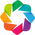

In [ ]:
from collections import Counter
import holoviews as hv
from holoviews import opts

hv.extension('matplotlib')

def direction_class(lb, ub):
    if lb < 0 and ub > 0:
        return "Reversible"
    if lb >= 0 and ub > 0:
        return "Forward"
    if lb < 0 and ub <= 0:
        return "Backward"
    return "Blocked"

def sankey_directions(before_bounds_csv, after_bounds_csv, title):

    color_map = {
    "Reversible": "#4C72B0",
    "Reversible (TFVA)":"#4C72B0",
    "Forward (TFVA)": "#55A868",
    "Backward (TFVA)": "#C44E52",
    "Blocked (TFVA)": "#444444"
    }

    before_bounds_df = pd.read_csv(before_bounds_csv, index_col=0)
    after_bounds_df  = pd.read_csv(after_bounds_csv,  index_col=0)

    before_bounds = list(zip(before_bounds_df["lb"], before_bounds_df["ub"]))
    after_bounds  = list(zip(after_bounds_df["lb"],  after_bounds_df["ub"]))

    before_classes = [direction_class(lb0, ub0) for lb0, ub0 in before_bounds]
    after_classes  = [direction_class(lb1, ub1) for lb1, ub1 in after_bounds]

    df = pd.DataFrame({
        "before": before_classes,
        "after": after_classes
    })

    df = df[df["before"] == "Reversible"]

    transition_counts = (
        df
        .value_counts()
        .reset_index(name="count")
    )

    transition_counts["before_node"] = transition_counts["before"]
    transition_counts["after_node"]  = transition_counts["after"] + " (TFVA)"


    sankey = hv.Sankey(
        transition_counts,
        kdims=["before_node", "after_node"],
        vdims="count"
    ).opts(
        node_color="index",
        cmap=color_map,
        edge_color="after_node",
        node_padding=30,
    )

    hv.save(sankey, "tfva_sankey.pdf")
    


In [88]:
sankey_directions("results/bounds/complete_ecoli_WT_Glc_before.csv", "results/bounds/ecoli_WT_Glc_metabolome_additional_tfva.csv", "Directions")

Exception: Format 'pdf' not supported by mode 'default'. Allowed formats: ['html', 'auto', 'png', 'widgets', 'scrubber', 'gif', 'auto', None]

In [25]:
from cobra.flux_analysis import find_blocked_reactions

def setup_model(condition, mets_tva=None):
    "Setup the ecoli model given a condition for physiological data"
    tmodel = gen_model(MODEL_NAME, INPUT_MODEL, INPUT_KEGGS, INPUT_REED, INPUT_INCHI, INPUT_GAMS, "", True, True)
    tmodel = apply_metabolome_physio_data(tmodel, condition, INPUT_EXP_DATA, INPUT_EXP_CONC, INPUT_METABOLOMICS, INPUT_GAMS, RELAX_EXP_FLUX_BOUNDS, INCLUDE_CO2, INCLUDE_O2, allow_other_excr=False, output_log="", flux_limit=100)

    blocked = find_blocked_reactions(tmodel, open_exchanges=False, processes=1)

    tmodel.remove_reactions(blocked, remove_orphans=True)
    remove_orphan_metabolites(tmodel)

    for rxn in tmodel.reactions:
        thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False)
    tmodel.update_thermo_info(fit_unknown_dfG0=True)

    #Set co2/o2 fluxes in correct directions
    tmodel.reactions.EX_co2.lower_bound = 0.0
    tmodel.reactions.EX_co2.upper_bound = 100.0
    
    tmodel.reactions.EX_o2.lower_bound = -100.0
    tmodel.reactions.EX_o2.upper_bound = 0.0

    # Apply results from metabolite TVA if present
    if mets_tva is not None:
        apply_met_tva(tmodel, mets_tva)
    
    return tmodel

In [21]:
# Create model for mets TVA
tmodel_glc = setup_model(CONDITIONS[0], mets_tva=None)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2731723
Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' c

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


*** Updating metabolite information ***
2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c N

KeyboardInterrupt: 

In [144]:
for m in tmodel_glc.metabolites:
    print(m.id, m.lower_bound.to("millimolar"), m.upper_bound.to("millimolar"))

2dhglcn_c 0.0001 millimolar 1.0 millimolar
nadh_c 0.0001 millimolar 2.83314013008588 millimolar
glcn_c 0.0001 millimolar 0.7510094609224821 millimolar
nad_c 0.0001 millimolar 21.680209268635856 millimolar
nadph_c 0.0001 millimolar 2.81973586946604 millimolar
nadp_c 0.0001 millimolar 0.06950785924102033 millimolar
2dhguln_c 0.0001 millimolar 1.0 millimolar
idon-L_c 0.0001 millimolar 1.0 millimolar
o2_c 0.1 millimolar 0.3 millimolar
h2o_c 1000.0 millimolar 1000.0 millimolar
pi_c 20.0 millimolar 25.0 millimolar
5dglcn_c 0.0001 millimolar 1.0 millimolar
ru5p-D_c 0.25292589900484286 millimolar 0.4342234967378932 millimolar
ara5p_c 0.0001 millimolar 1.0 millimolar
ACP_c 0.0001 millimolar 1.0 millimolar
atp_c 1.0739092842584388 millimolar 1.548858862398621 millimolar
ttdca_c 0.0001 millimolar 1.0 millimolar
amp_c 0.0001 millimolar 2.0997531815128596 millimolar
myrsACP_c 0.0001 millimolar 1.0 millimolar
ppi_c 0.0001 millimolar 1.0 millimolar
ttdcea_c 0.0001 millimolar 1.0 millimolar
tdeACP_c 0

In [145]:
save_conc_bounds_linear(tmodel_glc, "results/bounds/ecoli_WT_Glc_concs_before_tva.csv")

In [146]:
# Apply thermodynamic variables and additional respiratory constraint
tmodel_glc.m = None
tmodel_glc.objective = tmodel_glc.reactions.biomass_EX
tmodel_glc.add_TFBA_variables(qnorm='sep_norm')

add_rq_constraint(tmodel_glc, "WT-Glc_I", INPUT_EXP_DATA)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
>>>>>> RQ: 0.74 (vCO2 = 12.9 / vO2 = -17.4) ERR: 0.17932102098560615


In [50]:
# Optional: quickly optimize model to make sure it is feasible
tmodel_glc.m.Params.TimeLimit = 20
tmodel_glc.m.optimize()

Set parameter TimeLimit to value 20
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  20
NonConvex  2

Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
Optimize a model with 6731 rows, 5418 columns and 155311 nonzeros
Model fingerprint: 0x6407c076
Model has 1 quadratic constraint
Model has 300 simple general constraints
  300 ABS
Variable types: 4795 continuous, 623 integer (623 binary)
Coefficient statistics:
  Matrix range     [3e-06, 7e+05]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e-01, 1e+06]
  RHS range        [2e-14, 1e+05]
Presolve removed 4100 rows and 3194 columns
Presolve time: 0.38s
Presolved: 2635 rows, 2225 columns, 116

In [51]:
# Create one .mps.gz file containing all TVA scenarios for the metabolites
# Make sure output folder exists
tva_run_scenarios_one_model_mets(tmodel_glc, "ecoli", "WT_Glc", "../results/WT_Glc")

Set parameter MIPGap to value 0.001


Added 2dhglcn_c : <MVar ()>
array(<gurobi.Var ln_conc[0,0] (value -13.324994505486456)>)
Added nadh_c : <MVar ()>
array(<gurobi.Var ln_conc[0,1] (value -15.951434870181808)>)
Added glcn_c : <MVar ()>
array(<gurobi.Var ln_conc[0,2] (value -7.194092308513203)>)
Added nad_c : <MVar ()>
array(<gurobi.Var ln_conc[0,3] (value -16.11809565095832)>)
Added nadph_c : <MVar ()>
array(<gurobi.Var ln_conc[0,4] (value -13.315198368088057)>)
Added nadp_c : <MVar ()>
array(<gurobi.Var ln_conc[0,5] (value -16.11809565095832)>)
Added 2dhguln_c : <MVar ()>
array(<gurobi.Var ln_conc[0,6] (value -14.33724951069142)>)
Added idon-L_c : <MVar ()>
array(<gurobi.Var ln_conc[0,7] (value -6.907755278982137)>)
Added o2_c : <MVar ()>
array(<gurobi.Var ln_conc[0,8] (value -9.210340371976182)>)
Added h2o_c : <MVar ()>
array(<gurobi.Var ln_conc[0,9] (value 0.0)>)
Added pi_c : <MVar ()>
array(<gurobi.Var ln_conc[0,10] (value -3.6888794541139363)>)
Added 5dglcn_c : <MVar ()>
array(<gurobi.Var ln_conc[0,11] (value -16.11

In [24]:
# Recreate model with met TVA applied
tmodel_glc = setup_model(CONDITIONS[0], "results/ecoli_WT_Glc_mets_objval.txt")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2731723
Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' c

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


*** Updating metabolite information ***
2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c N

In [213]:
for m in tmodel_glc.metabolites:
    print(m.id, m.lower_bound, m.upper_bound)

2dhglcn_c 9.999999999999994e-05 millimolar 1.0000000000000002 millimolar
nadh_c 9.999999999999816e-05 millimolar 2.8331401300858796 millimolar
glcn_c 9.999999999999816e-05 millimolar 0.751009460922482 millimolar
nad_c 9.999999999999958e-05 millimolar 21.680209268635853 millimolar
nadph_c 9.999999999999994e-05 millimolar 2.8197358694660406 millimolar
nadp_c 9.999999999999816e-05 millimolar 0.06950785924102032 millimolar
2dhguln_c 9.999999999999958e-05 millimolar 1.0000000000000002 millimolar
idon-L_c 9.999999999999994e-05 millimolar 1.0000000000000002 millimolar
o2_c 0.10000000000000009 millimolar 0.2470978718328591 millimolar
h2o_c 1000.0000000000142 millimolar 1000.0000000000142 millimolar
pi_c 20.0 millimolar 25.0 millimolar
5dglcn_c 9.999999999999994e-05 millimolar 1.0000000000000147 millimolar
ru5p-D_c 0.2529258990048428 millimolar 0.43422349673789307 millimolar
ara5p_c 9.999999999999994e-05 millimolar 1.0000000000000002 millimolar
ACP_c 9.999999999999994e-05 millimolar 1.000000000

In [148]:
save_conc_bounds_linear(tmodel_glc, "results/bounds/ecoli_WT_Glc_concs_after_tva.csv")

('oaa_c', np.float64(0.17926440679309408))
('o2_c', np.float64(0.17658456606956696))
('h2o_c', np.float64(nan))
('ac_c', np.float64(0.17096692571075156))
('g3p_c', np.float64(0.14755322171095853))
('adphep-LD_c', np.float64(0.021063062431807666))
('adphep-DD_c', np.float64(0.021063062431783908))
('cbasp_c', np.float64(0.004967047668924307))
('dtmp_c', np.float64(0.0024640558574610116))
('gln-L_c', np.float64(1.614064437660545e-11))
('cmp_c', np.float64(5.46229728115577e-14))
('glu-L_c', np.float64(3.1086244689504383e-15))
('adp_c', np.float64(2.55351295663786e-15))
('g6p_c', np.float64(1.4432899320127035e-15))
('ru5p-D_c', np.float64(7.771561172376096e-16))
('pi_c', np.float64(0.0))
('ppcoa_c', np.float64(0.0))
('uacgam_c', np.float64(0.0))
('adn_c', np.float64(0.0))
('gsn_c', np.float64(0.0))
('2dhglcn_c', np.float64(-2.220446049250313e-16))
('nadph_c', np.float64(-2.220446049250313e-16))
('idon-L_c', np.float64(-2.220446049250313e-16))
('ara5p_c', np.float64(-2.220446049250313e-16))


invalid value encountered in scalar divide


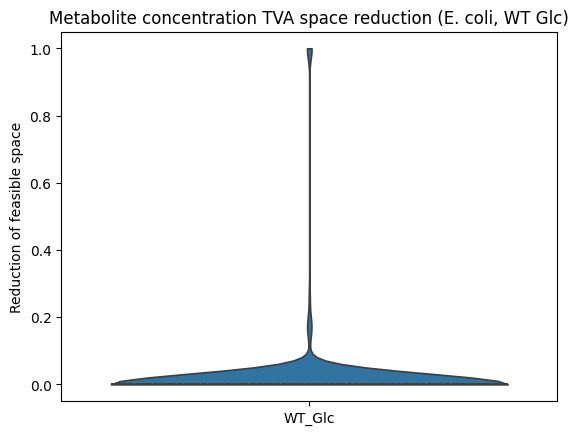

In [29]:
visualize_reduction_violin("results/bounds/ecoli_WT_Glc_concs_before_tva.csv", "results/bounds/ecoli_WT_Glc_concs_after_tva.csv", "Metabolite concentration TVA space reduction (E. coli, WT Glc)", log_scale=True)

In [25]:
# Recreate thermodynamic variables with new metabolite concentrations
tmodel_glc.m = None
tmodel_glc.objective = tmodel_glc.reactions.biomass_EX
tmodel_glc.add_TFBA_variables(qnorm='sep_norm')
add_rq_constraint(tmodel_glc, "WT-Glc_I", INPUT_EXP_DATA)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
>>>>>> RQ: 0.74 (vCO2 = 12.9 / vO2 = -17.4) ERR: 0.17932102098560615


In [212]:
# Create one .mps.gz file per reaction in the model
# Make sure output folder exists
tfva_run_scenarios_one_model(tmodel_glc, "ecoli", "WT_Glc", "../results/WT_Glc/parallel")

0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [26]:
# Save only the flux bounds from before and after the TFVA for Glc condition for later use
completed_ids = save_flux_bounds_tfva(tmodel_glc, "results/ecoli_WT_Glc_objvals_metabolome_additional.txt", "results/bounds/ecoli_WT_Glc_bounds_metabolome_additional_after_tfva.csv")

In [22]:
# Save complete flux bounds for the model
# Save the base bounds before any analysis
# Save bounds with normal FVA applied
# Save bounds with normal FVA applied + TFVA

save_flux_bounds_complete(tmodel_glc, "results/bounds/complete_ecoli_WT_Glc_before.csv")


In [27]:
fva_glc = flux_variability_analysis(tmodel_glc, None, processes=1)

In [28]:
apply_fva_bounds(tmodel_glc, fva_glc)

Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: 0.029478951950638044, 0.029478951950638044 ---> 0.029478951950638044, 0.029478951950638044
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -10.0, 9.990493037995918 ---> -10.0, 9.990493037995918
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -14.000000000000002, 13.986690253194288 ---> -14.0, 13.986690253194288
Before/after: -100.0, 99.90493037995918 ---> -100.0, 99.90493037995918
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 99.97052104804936 ---> -100.0, 99.97052104804936
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: 0.1937188271041929, 0

In [25]:
# Save the normal FVA bounds of the model
save_flux_bounds_complete(tmodel_glc, "results/bounds/complete_ecoli_WT_Glc_fva.csv")

In [29]:
apply_tfva_bounds(tmodel_glc, "results/bounds/ecoli_WT_Glc_bounds_metabolome_additional_after_tfva.csv")

2DGLCNRx: -100.0, 100.0 ---->  -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
2DGLCNRy: -100.0, 100.0 ---->  -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
2DGULRx: -100.0, 100.0 ---->  -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
2DGULRy: -100.0, 100.0 ---->  -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
A5PISO: 0.029478951950638044, 0.029478951950638044 ---->  0.0281752540556174, 0.0294789519508729
Before/after: 0.0281752540556174, 0.0294789519508729 ---> 0.0281752540556174, 0.0294789519508729
AACPS1: -100.0, 100.0 ---->  -99.99436494918882, 100.0
Before/after: -99.99436494918882, 100.0 ---> -99.99436494918882, 100.0
AACPS3: -100.0, 100.0 ---->  -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
ACGK: -100.0, 100.0 ---->  0.0, 91.03359248599904
Before/after: 0.0, 91.03359248599904 ---> 0.0, 91.03359248599904
ACGS: -100.0, 100.0 ---->  0.0, 93.12600376038236
Before/after: 0.0, 93.12600376038236 ---> 0.0, 93.126003760

In [30]:
# Save the TFVA bounds of the model
save_flux_bounds_complete(tmodel_glc, "results/bounds/ecoli_WT_Glc_metabolome_additional_tfva.csv")

In [31]:
difference_bounds("results/bounds/ecoli_WT_Glc_no_metabolome_tfva.csv", "results/bounds/ecoli_WT_Glc_metabolome_additional_tfva.csv")

Pandas(Index=10, _1=10, rxn='ABTA', lb=-0.0294789519508071, ub=99.3170608535056, width=99.3465398054564, width_comp=200.0)
Pandas(Index=23, _1=23, rxn='ACOTA', lb=-100.0, ub=0.0, width=100.0, width_comp=200.0)
Pandas(Index=88, _1=88, rxn='CBPS', lb=0.0, ub=100.0, width=100.0, width_comp=200.0)
Pandas(Index=94, _1=94, rxn='CMPN', lb=0.0, ub=99.79807734593317, width=99.79807734593317, width_comp=200.0)
Pandas(Index=100, _1=100, rxn='cytd', lb=0.0, ub=99.79807734593314, width=99.79807734593314, width_comp=200.0)
Pandas(Index=112, _1=112, rxn='DCTPD', lb=0.0, ub=99.57653243918318, width=99.57653243918318, width_comp=200.0)
Pandas(Index=148, _1=148, rxn='EDA', lb=0.0, ub=100.0, width=100.0, width_comp=200.0)
Pandas(Index=149, _1=149, rxn='EDD', lb=0.0, ub=100.0, width=100.0, width_comp=200.0)
Pandas(Index=276, _1=276, rxn='MCITD', lb=-0.1937188271052576, ub=100.0, width=100.19371882710526, width_comp=200.0)
Pandas(Index=277, _1=277, rxn='MCITL2', lb=-0.193718828170887, ub=100.0, width=100.1

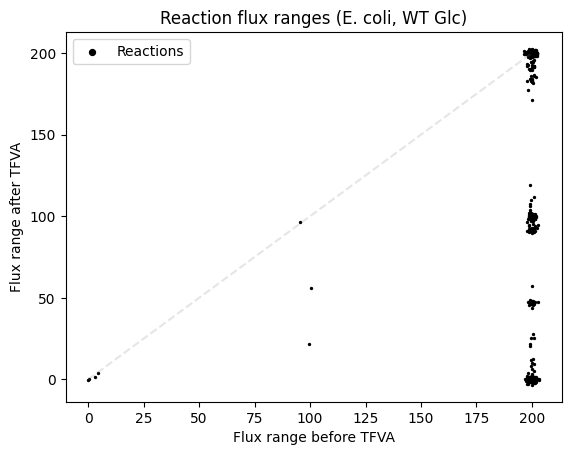

In [32]:
visualize_bounds("results/bounds/complete_ecoli_WT_Glc_before.csv", "results/bounds/ecoli_WT_Glc_metabolome_additional_tfva.csv", "Reaction flux ranges (E. coli, WT Glc)")



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.


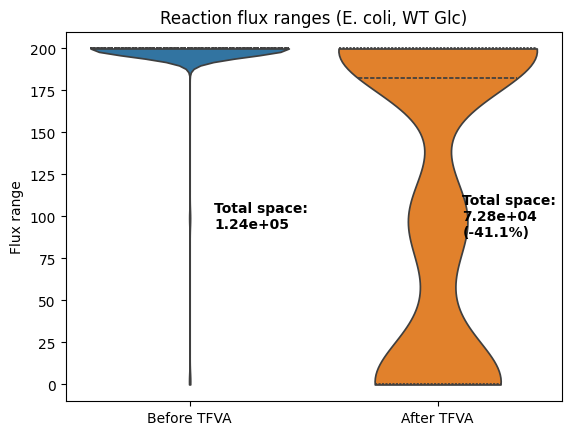

In [33]:
# Compare this to the version without metabolome data
visualize_bounds_violin("results/bounds/complete_ecoli_WT_Glc_before.csv", "results/bounds/ecoli_WT_Glc_metabolome_additional_tfva.csv", "Reaction flux ranges (E. coli, WT Glc)")

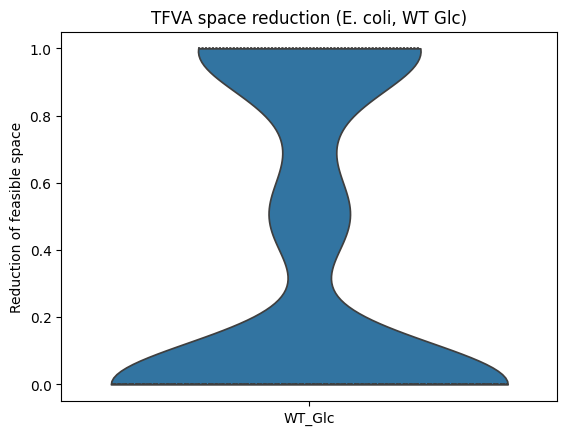

In [36]:
visualize_reduction_violin("results/bounds/complete_ecoli_WT_Glc_before.csv", "results/bounds/complete_ecoli_WT_Glc_tfva.csv", "TFVA space reduction (E. coli, WT Glc)")

In [14]:
# Now repeat the process for Acetate condition
tmodel_ace = setup_model(CONDITIONS[1], mets_tva=None)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2731723
Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' c

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


*** Updating metabolite information ***
2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c N

In [55]:
for m in tmodel_ace.metabolites:
    if m.id == "fdp_c":
        print(m.lower_bound.to("millimolar"), m.upper_bound.to("millimolar"))

0.13333846659863724 millimolar 0.1645957132634128 millimolar


In [15]:
# Apply thermodynamic variables and additional respiratory constraint
tmodel_ace.m = None
tmodel_ace.objective = tmodel_ace.reactions.biomass_EX
tmodel_ace.add_TFBA_variables(qnorm='sep_norm')

add_rq_constraint(tmodel_ace, "WT-Ace_I", INPUT_EXP_DATA)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
>>>>>> RQ: 0.98 (vCO2 = 15.7 / vO2 = -16.0) ERR: 0.32137831084665863


In [57]:
tmodel_ace.m.Params.TimeLimit = 20
tmodel_ace.m.optimize()

Set parameter TimeLimit to value 20
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  20
NonConvex  2

Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
Optimize a model with 6728 rows, 5411 columns and 155075 nonzeros
Model fingerprint: 0xcd0e544f
Model has 1 quadratic constraint
Model has 300 simple general constraints
  300 ABS
Variable types: 4789 continuous, 622 integer (622 binary)
Coefficient statistics:
  Matrix range     [3e-06, 7e+05]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [4e-02, 1e+06]
  RHS range        [2e-14, 1e+05]
Presolve removed 4136 rows and 3211 columns
Presolve time: 0.36s
Presolved: 2596 rows, 2201 columns, 115

In [19]:
tva_run_scenarios_one_model_mets_locally(tmodel_ace, "ecoli", "WT_Ace", "results")

Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 700
Added 2dhglcn_c : <MVar ()>
array(<gurobi.Var ln_conc[0,0] (value -10.988203135295427)>)
Added nadh_c : <MVar ()>
array(<gurobi.Var ln_conc[0,1] (value -5.866369595860432)>)
Added glcn_c : <MVar ()>
array(<gurobi.Var ln_conc[0,2] (value -7.194092308513203)>)
Added nad_c : <MVar ()>
array(<gurobi.Var ln_conc[0,3] (value -3.831355449844923)>)
Added nadph_c : <MVar ()>
array(<gurobi.Var ln_conc[0,4] (value -16.11809565095832)>)
Added nadp_c : <MVar ()>
array(<gurobi.Var ln_conc[0,5] (value -16.11809565095832)>)
Added 2dhguln_c : <MVar ()>
array(<gurobi.Var ln_conc[0,6] (value -10.231722295879628)>)
Added idon-L_c : <MVar ()>
array(<gurobi.Var ln_conc[0,7] (value -6.907755278982137)>)
Added o2_c : <MVar ()>
array(<gurobi.Var ln_conc[0,8] (value -8.305726057581222)>)
Added h2o_c : <MVar ()>
array(<gurobi.Var ln_conc[0,9] (value 0.0)>)
Added pi_c : <MVar ()>
array(<gurobi.Var ln_conc[0,10] (value -3.912023005428146)>)
A

In [20]:
print(tmodel_ace.metabolites[60])

cit_c


In [34]:
# Recreate model with met TVA applied
tmodel_ace = setup_model(CONDITIONS[1], "results/ecoli_WT_Ace_mets_objval.txt")

['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' created
unknown metabolite 'phthr[c]' created
unknown metabolite '4hthr[c]' created
unknown metabolite 'pi[c]' created
unknown metabolite '5dglcn[c]' created
unknown metabolite 'ru5p-D

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


*** Updating metabolite information ***
2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c N

In [22]:
tmodel_ace.m = None
tmodel_ace.objective = tmodel_ace.reactions.biomass_EX
tmodel_ace.add_TFBA_variables(qnorm='sep_norm')

add_rq_constraint(tmodel_ace, "WT-Ace_I", INPUT_EXP_DATA)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
>>>>>> RQ: 0.98 (vCO2 = 15.7 / vO2 = -16.0) ERR: 0.32137831084665863


In [23]:
tmodel_ace.m.Params.TimeLimit = 500
tmodel_ace.m.optimize()

Set parameter TimeLimit to value 500
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  500
NonConvex  2

Academic license 2731723 - for non-commercial use only - registered to l.___@student.rug.nl
Optimize a model with 6728 rows, 5411 columns and 155075 nonzeros
Model fingerprint: 0xa1bdbaa9
Model has 1 quadratic constraint
Model has 300 simple general constraints
  300 ABS
Variable types: 4789 continuous, 622 integer (622 binary)
Coefficient statistics:
  Matrix range     [3e-06, 7e+05]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [4e-02, 1e+06]
  RHS range        [2e-14, 1e+05]
Presolve removed 4149 rows and 3217 columns
Presolve time: 0.35s
Presolved: 2583 rows, 2195 columns, 1

In [36]:
# Save flux bounds from before and after the TFVA for Ace condition for later use
completed_ids = save_flux_bounds_tfva(tmodel_ace, "results/ecoli_WT_Ace_fluxes_objvals.txt", "results/bounds/ecoli_WT_Ace_bounds_metabolome_after_tfva.csv")
#save_flux_bounds_before_tfva(tmodel_ace, completed_ids, "results/bounds/ecoli_WT_Ace_bounds_before_tfva.csv")

In [37]:
# Save complete flux bounds for the model
# Save the base bounds before any analysis
# Save bounds with normal FVA applied
# Save bounds with normal FVA applied + TFVA

save_flux_bounds_complete(tmodel_ace, "results/bounds/complete_ecoli_WT_Ace_before.csv")
fva_ace = flux_variability_analysis(tmodel_ace, None, processes=1)
apply_fva_bounds(tmodel_ace, fva_ace)

# Save the normal FVA bounds of the model
save_flux_bounds_complete(tmodel_ace, "results/bounds/complete_ecoli_WT_Ace_fva.csv")
apply_tfva_bounds(tmodel_ace, "results/bounds/ecoli_WT_Ace_bounds_metabolome_after_tfva.csv")

# Save the TFVA bounds of the model
save_flux_bounds_complete(tmodel_ace, "results/bounds/ecoli_WT_Ace_metabolome_tfva.csv")

Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: 0.011282777118924411, 0.013948168186352014 ---> 0.011282777118924411, 0.013948168186352014
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -10.0, 9.996361304379146 ---> -10.0, 9.996361304379146
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -14.000000000000002, 13.994905826130807 ---> -14.0, 13.994905826130807
Before/after: -100.0, 99.96361304379147 ---> -100.0, 99.96361304379147
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 99.98871722288108 ---> -100.0, 99.98871722288108
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: -100.0, 100.0 ---> -100.0, 100.0
Before/after: 0.07414396392436043, 

In [26]:
tfva_run_scenarios_one_model(tmodel_ace, "ecoli", "WT_Ace", "../results/WT_Ace/parallel")

0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
